# Read Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
cancel_df = pd.read_csv('cancellations.csv')
cancel_df.head(5)

,ride_id,cancel_by,cancel_reason
0,R1,rider,driver_declined
1,R2,rider,changed_mind
2,R3,driver,no_driver_found
3,R4,driver,changed_mind
4,R5,rider,no_driver_found


In [3]:
cancel_df['ride_id'].nunique()

500

In [4]:
cancel_df['cancel_reason'].value_counts()

cancel_reason
long_wait          130
driver_declined    129
changed_mind       125
no_driver_found    116
Name: count, dtype: int64

In [5]:
cancel_df.shape

(500, 3)

In [6]:
drivers_on_trip_df = pd.read_csv('drivers_on_trip.csv')
drivers_on_trip_df.head(5)

,driver_id,dropoff_time,dropoff_location,trip_progress_pct
0,D1,2024-11-03 10:43:00,HN Outskirt 2,0.561488
1,D2,2024-11-03 12:03:00,HN Outskirt 2,0.335342
2,D3,2024-11-01 11:34:00,HCM Outskskirt 2,0.739241
3,D4,2024-11-03 02:53:00,HN Outskirt 2,0.569929
4,D5,2024-11-04 09:41:00,HN Outskirt 2,0.955387


In [7]:
drivers_on_trip_df[drivers_on_trip_df['driver_id'] == 'D1']

,driver_id,dropoff_time,dropoff_location,trip_progress_pct
0,D1,2024-11-03 10:43:00,HN Outskirt 2,0.561488


In [8]:
drivers_on_trip_df.shape

(1000, 4)

In [9]:
ride_requests_df = pd.read_csv('ride_requests.csv')
ride_requests_df.head(5)

,session_id,matched_driver_id,dispatch_time,dispatch_type,eta,accept_distance
0,S303,D155,2024-11-01 20:44:00,forward,5.40,1.78
1,S421,D565,2024-11-04 12:21:00,legacy,7.57,2.14
2,S1270,D619,2024-11-04 06:25:00,legacy,2.33,2.59
3,S1744,D357,2024-11-01 00:16:00,forward,4.53,4.91
4,S1261,D816,2024-11-01 22:58:00,legacy,6.25,1.28


In [10]:
ride_requests_df.shape

(1800, 6)

In [11]:
zero_session_df = pd.read_csv('zero_sessions.csv')
zero_session_df.head(5)

,session_id,region,vehicle_type,created_time,expired_time
0,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26
1,S2,HN Outskirt 2,3,2024-11-03 07:14:00,2024-11-03 07:22:47
2,S3,HCM Outskirt 1,49,2024-11-02 23:06:00,2024-11-02 23:10:22
3,S4,HN Outskirt 1,9,2024-11-01 18:27:00,2024-11-01 18:34:00
4,S5,HN Outskirt 1,49,2024-11-01 00:05:00,2024-11-01 00:08:02


In [12]:
zero_session_df.shape

(2000, 5)

# Analysis

### Zero Session

In [13]:
# Q1: Zero Valid Rate for Bike and Car transport across different outskirts.

In [14]:
# 1. Create ride_id
# -------------------------
ride_requests = ride_requests_df.copy()
ride_requests["ride_id"] = ["R" + str(i+1) for i in range(len(ride_requests))]

In [15]:
# 2. Merge zero_sessions with ride_requests
# -------------------------
zero_sessions = zero_session_df.merge(
    ride_requests[["session_id", "ride_id", "matched_driver_id"]],
    on="session_id",
    how="left"
)

In [16]:
# 3. Check driver availability
# -------------------------
# Assume: if a driver_id appears in drivers_on_trip, that driver is active.
# Logic: if matched_driver_id is NaN but driver_id exists in drivers_on_trip, then session is NOT a valid zero.
zero_sessions["driver_active"] = zero_sessions["matched_driver_id"].isin(drivers_on_trip_df["driver_id"])

In [17]:
# 4. Check cancellations
# -------------------------
zero_sessions = zero_sessions.merge(
    cancel_df[["ride_id", "cancel_by"]],
    on="ride_id",
    how="left"
)

zero_sessions["was_cancelled"] = zero_sessions["cancel_by"].notna()

In [18]:
# 5. Define valid zero
# -------------------------
zero_sessions["is_valid_zero"] = (
    zero_sessions["matched_driver_id"].isna() &       # no driver matched
    ~zero_sessions["driver_active"] &                 # no active driver
    ~zero_sessions["was_cancelled"]                   # no cancellation
)

In [19]:
zero_sessions.head()

,session_id,region,vehicle_type,created_time,expired_time,ride_id,matched_driver_id,driver_active,cancel_by,was_cancelled,is_valid_zero
0,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R601,D71,True,NaN,False,False
1,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R844,D486,True,NaN,False,False
2,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R1105,D551,True,NaN,False,False
3,S2,HN Outskirt 2,3,2024-11-03 07:14:00,2024-11-03 07:22:47,R1451,D238,True,NaN,False,False
4,S3,HCM Outskirt 1,49,2024-11-02 23:06:00,2024-11-02 23:10:22,R1130,D51,True,NaN,False,False


In [20]:
# Map vehicle_type into Bike / Car
vehicle_map = {3: "Bike", 6: "Car", 9: "Car", 37: "Bike", 49: "Bike"}
zero_sessions["vehicle_label"] = zero_sessions["vehicle_type"].map(vehicle_map)

# Compute metric by vehicle_label and region
metrics = (
    zero_sessions.groupby(["region", "vehicle_label"])
    .agg(
        total_zero=("session_id", "count"),
        valid_zero=("is_valid_zero", "sum")
    )
    .reset_index()
)

metrics["zero_valid_rate"] = metrics["valid_zero"] / metrics["total_zero"]

print(metrics)

             region vehicle_label  total_zero  valid_zero  zero_valid_rate
0    HCM Outskirt 1          Bike         404         141         0.349010
1    HCM Outskirt 1           Car         278          80         0.287770
2  HCM Outskskirt 2          Bike         343         120         0.349854
3  HCM Outskskirt 2           Car         289          88         0.304498
4     HN Outskirt 1          Bike         408         116         0.284314
5     HN Outskirt 1           Car         249          87         0.349398
6     HN Outskirt 2          Bike         412         114         0.276699
7     HN Outskirt 2           Car         244          81         0.331967


In [21]:
import matplotlib.pyplot as plt

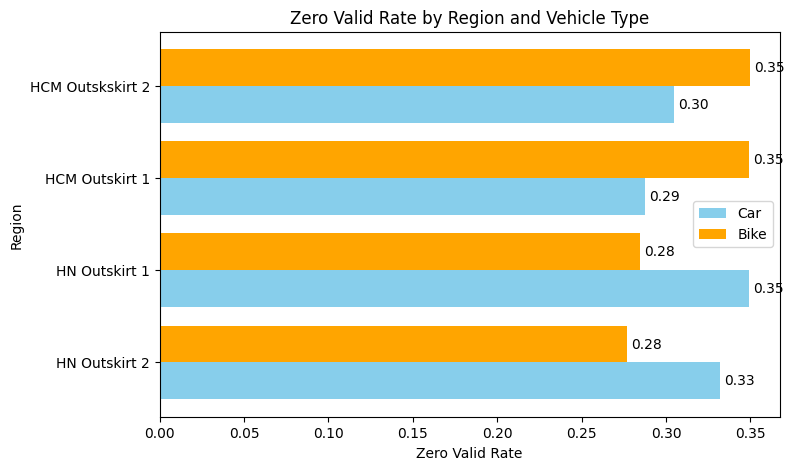

In [22]:
# Pivot to wide format (Car vs Bike per region)
# Pivot to wide format (Car vs Bike per region)
pivot_df = metrics.pivot(index="region", columns="vehicle_label", values="zero_valid_rate").fillna(0)

# Choose vehicle type to sort by
sort_vehicle = "Bike"   # change to "Bike" if needed
pivot_df = pivot_df.sort_values(by=sort_vehicle, ascending=True)

# Plot twin horizontal bars
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.4
y = range(len(pivot_df))

bars_car = ax.barh([i - bar_width/2 for i in y], pivot_df["Car"], height=bar_width, label="Car", color="skyblue")
bars_bike = ax.barh([i + bar_width/2 for i in y], pivot_df["Bike"], height=bar_width, label="Bike", color="orange")

ax.set_yticks(y)
ax.set_yticklabels(pivot_df.index)
ax.set_xlabel("Zero Valid Rate")
ax.set_ylabel("Region")
ax.set_title("Zero Valid Rate by Region and Vehicle Type")
ax.legend()

# Add labels with 2 decimal places
ax.bar_label(bars_car, fmt="%.2f", padding=3)
ax.bar_label(bars_bike, fmt="%.2f", padding=3)

plt.show()

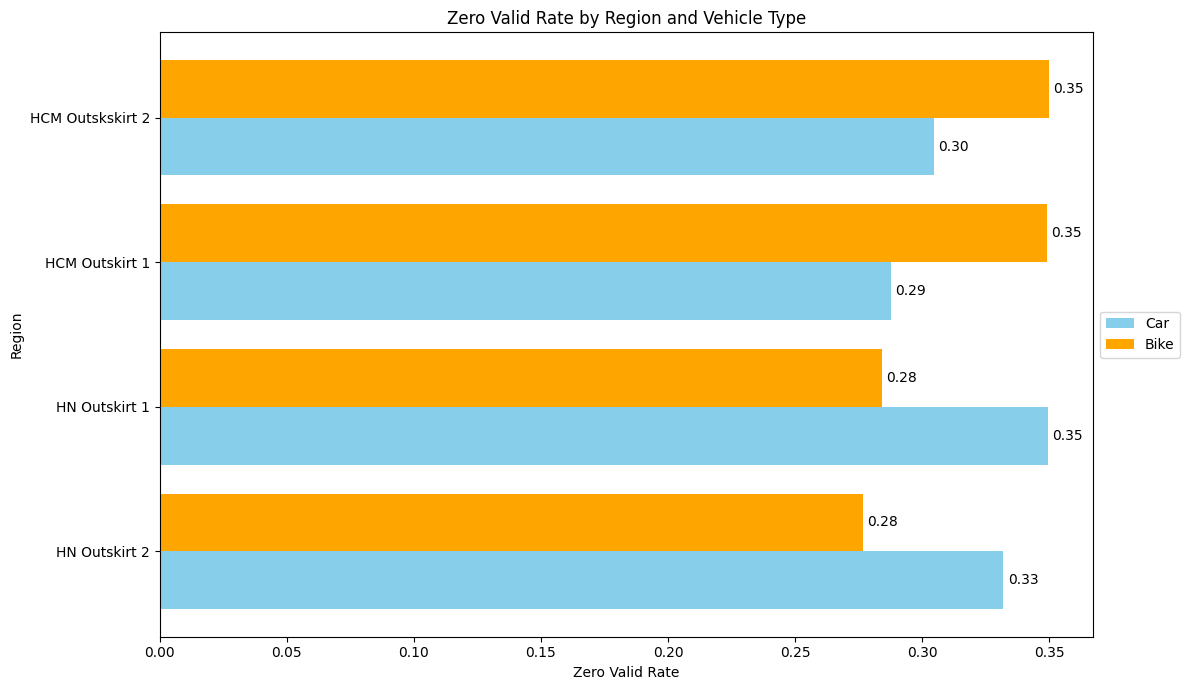

In [86]:
# Plot twin horizontal bars
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.4
y = range(len(pivot_df))

bars_car = ax.barh([i - bar_width/2 for i in y], pivot_df["Car"], height=bar_width, label="Car", color="skyblue")
bars_bike = ax.barh([i + bar_width/2 for i in y], pivot_df["Bike"], height=bar_width, label="Bike", color="orange")

ax.set_yticks(y)
ax.set_yticklabels(pivot_df.index)
ax.set_xlabel("Zero Valid Rate")
ax.set_ylabel("Region")
ax.set_title("Zero Valid Rate by Region and Vehicle Type")

# Move legend outside
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Add labels with 2 decimal places
ax.bar_label(bars_car, fmt="%.2f", padding=3)
ax.bar_label(bars_bike, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

In [23]:
# Q2: Identify trends over weeks for HCM and Hanoi outskirts.

In [24]:
# Ensure created_time is datetime
zero_sessions["created_time"] = pd.to_datetime(zero_sessions["created_time"], errors="coerce")

# Add week column (week start date)
zero_sessions["week"] = zero_sessions["created_time"].dt.to_period("W").apply(lambda r: r.start_time)

In [25]:
zero_sessions.head()

,session_id,region,vehicle_type,created_time,expired_time,ride_id,matched_driver_id,driver_active,cancel_by,was_cancelled,is_valid_zero,vehicle_label,week
0,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R601,D71,True,NaN,False,False,Car,2024-10-28
1,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R844,D486,True,NaN,False,False,Car,2024-10-28
2,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R1105,D551,True,NaN,False,False,Car,2024-10-28
3,S2,HN Outskirt 2,3,2024-11-03 07:14:00,2024-11-03 07:22:47,R1451,D238,True,NaN,False,False,Bike,2024-10-28
4,S3,HCM Outskirt 1,49,2024-11-02 23:06:00,2024-11-02 23:10:22,R1130,D51,True,NaN,False,False,Bike,2024-10-28


In [26]:
# ISO week number from calendar
zero_sessions["week_number"] = zero_sessions["created_time"].dt.isocalendar().week
zero_sessions["week_by_number"] = "w" + zero_sessions["week_number"].astype(str)

In [27]:
zero_sessions.head()

,session_id,region,vehicle_type,created_time,expired_time,ride_id,matched_driver_id,driver_active,cancel_by,was_cancelled,is_valid_zero,vehicle_label,week,week_number,week_by_number
0,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R601,D71,True,NaN,False,False,Car,2024-10-28,44,w44
1,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R844,D486,True,NaN,False,False,Car,2024-10-28,44,w44
2,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,R1105,D551,True,NaN,False,False,Car,2024-10-28,44,w44
3,S2,HN Outskirt 2,3,2024-11-03 07:14:00,2024-11-03 07:22:47,R1451,D238,True,NaN,False,False,Bike,2024-10-28,44,w44
4,S3,HCM Outskirt 1,49,2024-11-02 23:06:00,2024-11-02 23:10:22,R1130,D51,True,NaN,False,False,Bike,2024-10-28,44,w44


In [28]:
weekly_trends = (
    zero_sessions.groupby(["week_by_number", "region", "vehicle_label"])
    .agg(
        total_zero=("session_id", "count"),
        valid_zero=("is_valid_zero", "sum")
    )
    .reset_index()
)

weekly_trends["zero_valid_rate"] = weekly_trends["valid_zero"] / weekly_trends["total_zero"]


In [29]:
weekly_trends

,week_by_number,region,vehicle_label,total_zero,valid_zero,zero_valid_rate
0,w44,HCM Outskirt 1,Bike,281,108,0.384342
1,w44,HCM Outskirt 1,Car,200,59,0.295000
2,w44,HCM Outskskirt 2,Bike,251,88,0.350598
3,w44,HCM Outskskirt 2,Car,226,62,0.274336
4,w44,HN Outskirt 1,Bike,312,91,0.291667
5,w44,HN Outskirt 1,Car,204,67,0.328431
6,w44,HN Outskirt 2,Bike,286,71,0.248252
7,w44,HN Outskirt 2,Car,186,67,0.360215
8,w45,HCM Outskirt 1,Bike,123,33,0.268293
9,w45,HCM Outskirt 1,Car,78,21,0.269231


In [90]:
hcm_weekly_trend = weekly_trends[weekly_trends['region'].str.contains("HCM", case=False, na=False)]
hcm_weekly_trend

,week_by_number,region,vehicle_label,total_zero,valid_zero,zero_valid_rate
0,w44,HCM Outskirt 1,Bike,281,108,0.384342
1,w44,HCM Outskirt 1,Car,200,59,0.295000
2,w44,HCM Outskskirt 2,Bike,251,88,0.350598
3,w44,HCM Outskskirt 2,Car,226,62,0.274336
8,w45,HCM Outskirt 1,Bike,123,33,0.268293
9,w45,HCM Outskirt 1,Car,78,21,0.269231
10,w45,HCM Outskskirt 2,Bike,92,32,0.347826
11,w45,HCM Outskskirt 2,Car,63,26,0.412698


C:\Users\USER\AppData\Local\Temp\ipykernel_4608\2488211484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hcm_weekly_trend["region_vehicle"] = hcm_weekly_trend["region"] + " - " + hcm_weekly_trend["vehicle_label"]


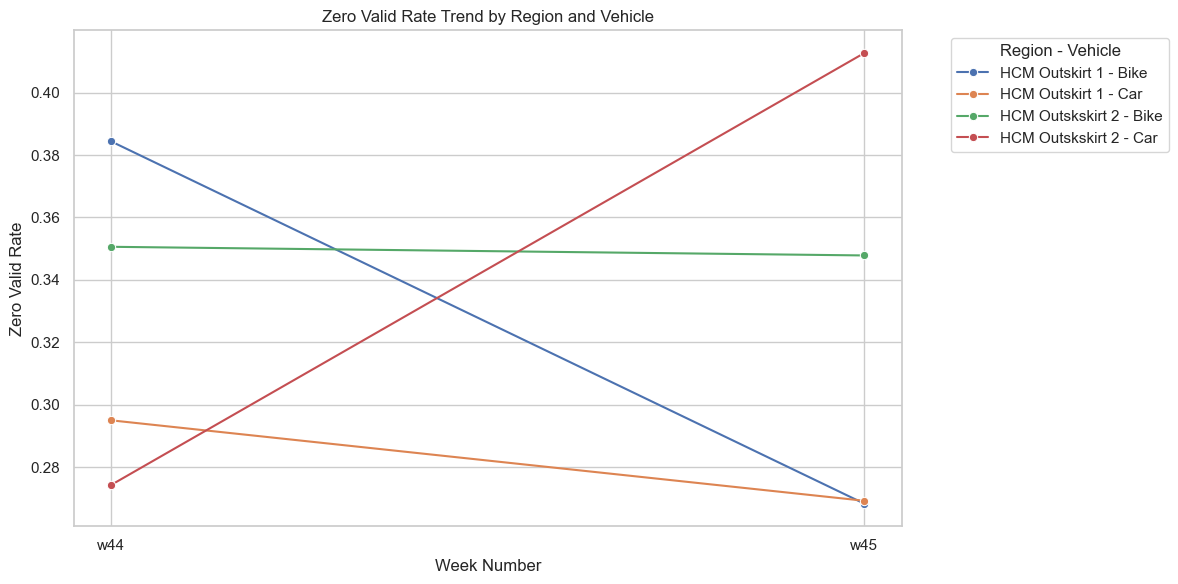

In [92]:
# Combine region + vehicle_label for color/hue
hcm_weekly_trend["region_vehicle"] = hcm_weekly_trend["region"] + " - " + hcm_weekly_trend["vehicle_label"]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hcm_weekly_trend,
    x="week_by_number",
    y="zero_valid_rate",
    hue="region_vehicle",
    marker="o"
)
plt.title("Zero Valid Rate Trend by Region and Vehicle")
plt.xlabel("Week Number")
plt.ylabel("Zero Valid Rate")
plt.legend(title="Region - Vehicle", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [91]:
hanoi_weekly_trend = weekly_trends[weekly_trends['region'].str.contains("HN", case=False, na=False)]
hanoi_weekly_trend

,week_by_number,region,vehicle_label,total_zero,valid_zero,zero_valid_rate
4,w44,HN Outskirt 1,Bike,312,91,0.291667
5,w44,HN Outskirt 1,Car,204,67,0.328431
6,w44,HN Outskirt 2,Bike,286,71,0.248252
7,w44,HN Outskirt 2,Car,186,67,0.360215
12,w45,HN Outskirt 1,Bike,96,25,0.260417
13,w45,HN Outskirt 1,Car,45,20,0.444444
14,w45,HN Outskirt 2,Bike,126,43,0.341270
15,w45,HN Outskirt 2,Car,58,14,0.241379


C:\Users\USER\AppData\Local\Temp\ipykernel_4608\1301170605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hanoi_weekly_trend["region_vehicle"] = hanoi_weekly_trend["region"] + " - " + hanoi_weekly_trend["vehicle_label"]


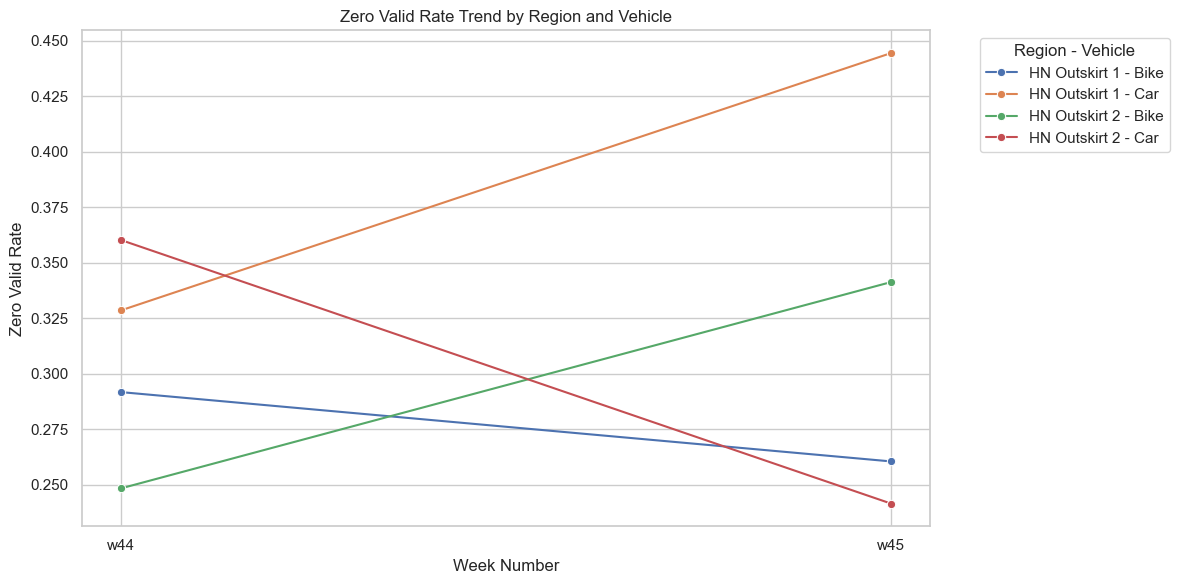

In [94]:
# Combine region + vehicle_label for color/hue
hanoi_weekly_trend["region_vehicle"] = hanoi_weekly_trend["region"] + " - " + hanoi_weekly_trend["vehicle_label"]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hanoi_weekly_trend,
    x="week_by_number",
    y="zero_valid_rate",
    hue="region_vehicle",
    marker="o"
)
plt.title("Zero Valid Rate Trend by Region and Vehicle")
plt.xlabel("Week Number")
plt.ylabel("Zero Valid Rate")
plt.legend(title="Region - Vehicle", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

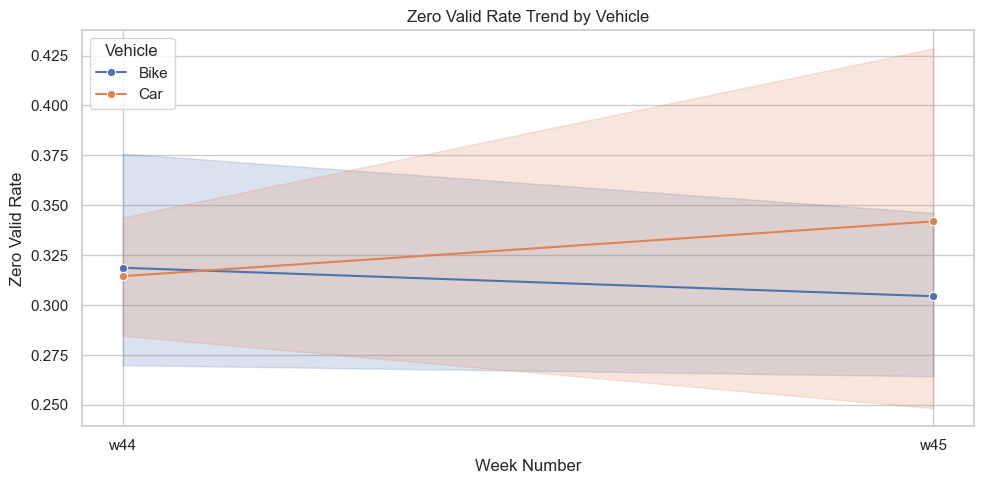

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# --- 1. Line Chart: Zero Valid Rate over Weeks ---
plt.figure(figsize=(10, 5))
sns.lineplot(data=weekly_trends, x="week_by_number", y="zero_valid_rate", hue="vehicle_label", marker="o")
plt.title("Zero Valid Rate Trend by Vehicle")
plt.xlabel("Week Number")
plt.ylabel("Zero Valid Rate")
plt.legend(title="Vehicle")
plt.tight_layout()
plt.show()



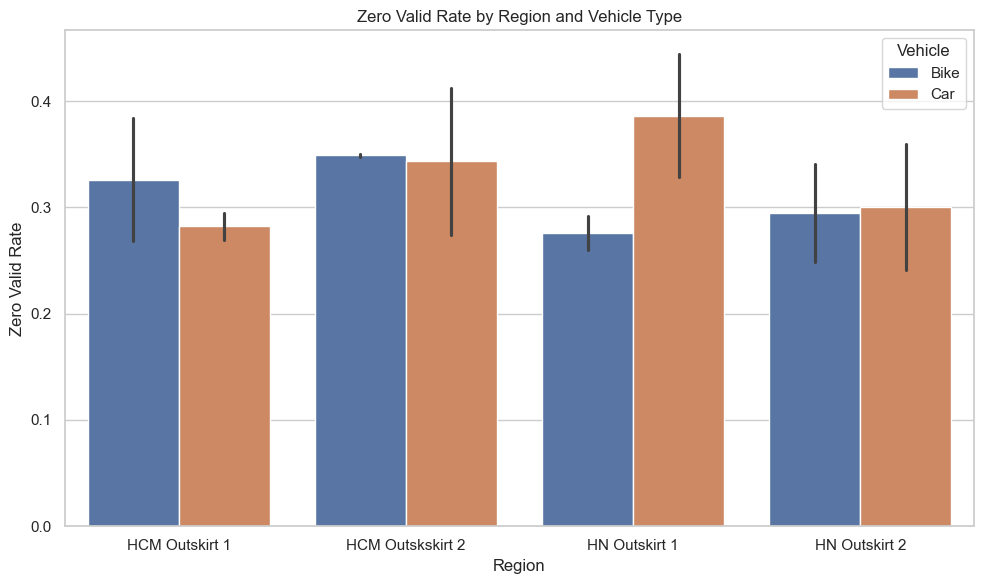

In [88]:
# --- 2. Grouped Bar Chart: Regions ---
plt.figure(figsize=(10, 6))
sns.barplot(data=weekly_trends, x="region", y="zero_valid_rate", hue="vehicle_label")
plt.title("Zero Valid Rate by Region and Vehicle Type")
plt.xlabel("Region")
plt.ylabel("Zero Valid Rate")
plt.legend(title="Vehicle")
plt.tight_layout()
plt.show()

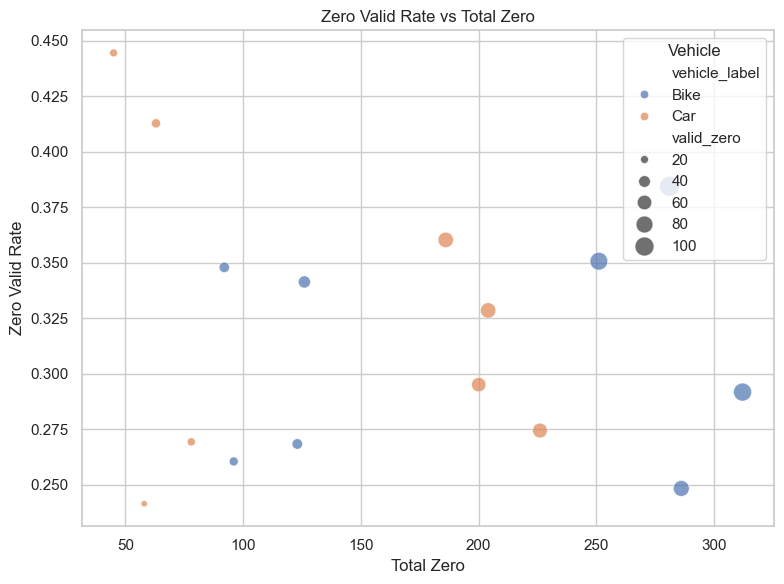

In [89]:
# --- 3. Scatter Plot: Rate vs Volume ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=weekly_trends, 
    x="total_zero", 
    y="zero_valid_rate", 
    hue="vehicle_label", 
    size="valid_zero", 
    sizes=(20, 200), 
    alpha=0.7
)
plt.title("Zero Valid Rate vs Total Zero")
plt.xlabel("Total Zero")
plt.ylabel("Zero Valid Rate")
plt.legend(title="Vehicle")
plt.tight_layout()
plt.show()

In [30]:
# Step 1: Select needed columns and ensure datetime
sessions = zero_session_df[['session_id', 'vehicle_type', 'created_time']].copy()
sessions['created_time'] = pd.to_datetime(sessions['created_time'])

# Step 2: Sort by session_id and created_time
sessions.sort_values(['session_id', 'created_time'], inplace=True)

# Step 3: Compute next session time within each session_id
sessions['next_created_time'] = sessions.groupby('session_id')['created_time'].shift(-1)
sessions['time_to_next'] = (sessions['next_created_time'] - sessions['created_time']).dt.total_seconds()

# Step 4: Flag rebook within 10 mins
sessions['rebook_within_10min'] = sessions['time_to_next'].le(600)

# Step 5: Map Vehicle Type
# Map vehicle_type into Bike / Car
vehicle_map = {3: "Bike", 6: "Car", 9: "Car", 37: "Bike", 49: "Bike"}
sessions["vehicle_label"] = zero_sessions["vehicle_type"].map(vehicle_map)

# Step 6: Calculate rebook rate per vehicle_type
summary = sessions.groupby('vehicle_label').agg(
    total_sessions=('session_id', 'count'),
    rebooks_within_10min=('rebook_within_10min', 'sum')
).reset_index()

summary['rebook_rate_pct'] = (summary['rebooks_within_10min'] / summary['total_sessions'] * 100).round(2)

print(summary)

  vehicle_label  total_sessions  rebooks_within_10min  rebook_rate_pct
0          Bike            1199                     0              0.0
1           Car             801                     0              0.0


In [31]:
# Q3: Highlight the difference in rebook-within-10-mins rate between vehicle types

In [32]:
# 1. Create ride_id
# -------------------------
ride_requests = ride_requests_df.copy()
ride_requests["ride_id"] = ["R" + str(i+1) for i in range(len(ride_requests))]

In [33]:
# 2.Merge zero_session with ride_request on session_id
merged = zero_session_df.merge(ride_requests, on="session_id", how="left")

In [34]:

# Ensure datetime
merged["created_time"] = pd.to_datetime(merged["created_time"])

In [35]:
# Sort
merged = merged.sort_values(["ride_id", "created_time"])

In [36]:
# Group by ride_id only
merged["next_created_time"] = merged.groupby("ride_id")["created_time"].shift(-1)
merged["time_to_next"] = (merged["next_created_time"] - merged["created_time"]).dt.total_seconds()

In [37]:
# Map vehicle_type into Bike / Car
vehicle_map = {3: "Bike", 6: "Car", 9: "Car", 37: "Bike", 49: "Bike"}
merged["vehicle_label"] = merged["vehicle_type"].map(vehicle_map)


In [38]:
# Flag rebook within 10 mins (600 seconds)
merged['rebook_within_10min'] = merged['time_to_next'].le(600)  # True if ≤ 600s

In [39]:
# Calculate rebook rate per vehicle_type
summary = merged.groupby('vehicle_type').agg(
    total_sessions=('ride_id', 'count'),
    rebooks_within_10min=('rebook_within_10min', 'sum')
).reset_index()

summary['rebook_rate_pct'] = (summary['rebooks_within_10min'] / summary['total_sessions'] * 100).round(2)

print(summary)

   vehicle_type  total_sessions  rebooks_within_10min  rebook_rate_pct
0             3             371                     0              0.0
1             6             360                     0              0.0
2             9             364                     0              0.0
3            37             329                     0              0.0
4            49             376                     0              0.0


### Coverage Opportunity Estimation

In [40]:
# Q4: Using Range 1 (2km, 3 mins) and Range 2 (3km, 5 mins), simulate the percentage of valid sessions and potential sessions for Bike and Car.

* Valid Session = session where a rider actually got matched (ride_requests exists for that session). If the matched driver’s dropoff was within Range 1 or Range 2 → count under that range.

* Potential Session = session with no actual match (no ride request or no matched_driver_id), but there exists a driver whose dropoff_time and dropoff_location satisfy the range constraint.

In [41]:
drivers = drivers_on_trip_df.copy()

In [42]:
zero_sessions = zero_session_df.copy()

In [43]:
# ---- Step 1: Simulate driver dropoff distances (random 0–5 km) ----
np.random.seed(42)
drivers["dropoff_distance_km"] = np.random.uniform(0, 5, size=len(drivers))

In [44]:

# ---- Step 2: Merge sessions with ride requests to see matched vs unmatched ----
sessions = zero_sessions.merge(ride_requests_df[["session_id", "matched_driver_id"]], on="session_id", how="left")

In [45]:
# Map vehicle_type into Bike / Car
vehicle_map = {3: "Bike", 6: "Car", 9: "Car", 37: "Bike", 49: "Bike"}
sessions["vehicle_label"] = sessions["vehicle_type"].map(vehicle_map)

In [46]:
# ---- Step 3: Define helper to check valid match ----
def classify_session(row, drivers, range_km, range_min):
    # Filter drivers dropping off after session created_time but before expired_time
    nearby = drivers[
        (drivers["dropoff_time"] >= row["created_time"]) &
        (drivers["dropoff_time"] <= row["expired_time"]) &
        (drivers["dropoff_distance_km"] <= range_km)
    ]
    
    if nearby.empty:
        return "No driver nearby"
    
    # If already matched and conditions satisfied → Valid
    if pd.notnull(row["matched_driver_id"]):
        return "Valid"
    else:
        return "Potential"


In [47]:
# ---- Step 4: Apply for Range 1 (2 km, 3 mins) and Range 2 (3 km, 5 mins) ----
sessions["range1_status"] = sessions.apply(
    classify_session, axis=1, drivers=drivers, range_km=2, range_min=3
)

sessions["range2_status"] = sessions.apply(
    classify_session, axis=1, drivers=drivers, range_km=3, range_min=5
)

In [48]:
# ---- Step 5: Calculate percentages ----
def calc_percentage(col):
    results = {}
    for vehicle in ["Bike", "Car"]:
        subset = sessions[sessions["vehicle_label"] == vehicle]
        total = len(subset)
        if total == 0:
            results[vehicle] = {"Valid %": 0, "Potential %": 0}
        else:
            valid = (subset[col] == "Valid").sum() / total * 100
            potential = (subset[col] == "Potential").sum() / total * 100
            results[vehicle] = {"Valid %": valid, "Potential %": potential}
    return results

range1_result = calc_percentage("range1_status")
range2_result = calc_percentage("range2_status")

print("Range 1 (2km, 3 mins):", range1_result)
print("Range 2 (3km, 5 mins):", range2_result)

Range 1 (2km, 3 mins): {'Bike': {'Valid %': np.float64(23.867262284620296), 'Potential %': np.float64(11.423101467772815)}, 'Car': {'Valid %': np.float64(27.735849056603772), 'Potential %': np.float64(12.452830188679245)}}
Range 2 (3km, 5 mins): {'Bike': {'Valid %': np.float64(32.29100191448628), 'Potential %': np.float64(15.315890236119975)}, 'Car': {'Valid %': np.float64(37.16981132075471), 'Potential %': np.float64(16.132075471698112)}}


In [49]:
# Q5: Provide conversion rates and estimate how many zero sessions could realistically be covered each week.

In [50]:
zero_sessions = zero_session_df.copy()

In [51]:
sessions = zero_sessions.merge(ride_requests_df[["session_id", "matched_driver_id"]], on="session_id", how="left")

In [52]:
sessions.head()

,session_id,region,vehicle_type,created_time,expired_time,matched_driver_id
0,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,D71
1,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,D486
2,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,D551
3,S2,HN Outskirt 2,3,2024-11-03 07:14:00,2024-11-03 07:22:47,D238
4,S3,HCM Outskirt 1,49,2024-11-02 23:06:00,2024-11-02 23:10:22,D51


In [53]:
# Ensure created_time is datetime
sessions["created_time"] = pd.to_datetime(sessions["created_time"])

# Extract week (ISO week or week-start date)
sessions["week"] = sessions["created_time"].dt.to_period("W").apply(lambda r: r.start_time)

In [54]:
# --- 1. Conversion Rate (all sessions) ---
conversion_rate = (
    sessions.assign(is_matched=sessions["matched_driver_id"].notna())
    .groupby("week")["is_matched"]
    .mean()
    .reset_index(name="conversion_rate")
)

In [55]:
conversion_rate

,week,conversion_rate
0,2024-10-28,0.684995
1,2024-11-04,0.685756


In [56]:
zero_sessions = zero_session_df.copy()

In [57]:
session_for_coverage = zero_sessions.merge(ride_requests_df[["session_id", "matched_driver_id"]], on="session_id", how="left")

In [58]:
# ------------------ Step 2. Define helper ------------------
def classify_session(row, drivers, range_km, range_min):
    """Check if session is covered by any driver within distance + time window."""
    nearby = drivers[
        (drivers["dropoff_time"] >= row["created_time"]) &
        (drivers["dropoff_time"] <= row["expired_time"]) &
        (drivers["dropoff_distance_km"] <= range_km)
    ]
    return "Covered" if not nearby.empty else "Not covered"

In [59]:
# ------------------ Step 3. Apply classification ------------------
# Range 1: 2 km, 3 min
session_for_coverage["range1_status"] = session_for_coverage.apply(
    classify_session, axis=1, drivers=drivers, range_km=2, range_min=3
)

# Range 2: 3 km, 5 min
session_for_coverage["range2_status"] = session_for_coverage.apply(
    classify_session, axis=1, drivers=drivers, range_km=3, range_min=5
)

In [60]:
session_for_coverage.head()

,session_id,region,vehicle_type,created_time,expired_time,matched_driver_id,range1_status,range2_status
0,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,D71,Not covered,Not covered
1,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,D486,Not covered,Not covered
2,S1,HN Outskirt 1,6,2024-11-01 00:47:00,2024-11-01 00:50:26,D551,Not covered,Not covered
3,S2,HN Outskirt 2,3,2024-11-03 07:14:00,2024-11-03 07:22:47,D238,Not covered,Not covered
4,S3,HCM Outskirt 1,49,2024-11-02 23:06:00,2024-11-02 23:10:22,D51,Not covered,Not covered


In [61]:
# ------------------ Step 4. Weekly coverage rate ------------------
# Ensure created_time is datetime
session_for_coverage["created_time"] = pd.to_datetime(session_for_coverage["created_time"])
session_for_coverage["week"] = session_for_coverage["created_time"].dt.to_period("W").dt.start_time

In [62]:
coverage_rate_range1 = (
    session_for_coverage.assign(is_covered=session_for_coverage["range1_status"].eq("Covered"))
    .groupby("week")["is_covered"]
    .mean()
    .reset_index(name="coverage_rate_range1")
)

In [63]:
coverage_rate_range1

,week,coverage_rate_range1
0,2024-10-28,0.380781
1,2024-11-04,0.349486


In [64]:
coverage_rate_range2 = (
    session_for_coverage.assign(is_covered=session_for_coverage["range2_status"].eq("Covered"))
    .groupby("week")["is_covered"]
    .mean()
    .reset_index(name="coverage_rate_range2")
)

In [65]:
# ------------------ Step 5. Merge for final result ------------------
coverage_rates = pd.merge(coverage_rate_range1, coverage_rate_range2, on="week", how="outer")

print(coverage_rates)

        week  coverage_rate_range1  coverage_rate_range2
0 2024-10-28              0.380781              0.487667
1 2024-11-04              0.349486              0.531571


### Cancellation & Risk Monitoring

In [66]:
# Q6: Compare rider and driver cancellation rates between legacy vs forward dispatch.

In [67]:
ride_requests = ride_requests_df.copy()
ride_requests["ride_id"] = ["R" + str(i+1) for i in range(len(ride_requests))]

In [68]:
# Merge ride_requests with cancellations on ride_id
requests_with_cancels = ride_requests.merge(
    cancel_df, on="ride_id", how="left")

In [69]:
# Add indicator: whether cancelled or not
requests_with_cancels["is_cancelled"] = requests_with_cancels["cancel_by"].notna()

In [70]:
# Total requests per dispatch_type
total_requests = (
    ride_requests.groupby("dispatch_type")
    .size()
    .reset_index(name="total_requests")
)

In [71]:
# Cancellations grouped by dispatch_type and who cancelled
cancel_counts = (
    requests_with_cancels[requests_with_cancels["is_cancelled"]]
    .groupby(["dispatch_type", "cancel_by"])
    .size()
    .reset_index(name="cancel_count")
)

In [72]:
# Merge and calculate rates
cancel_rates = cancel_counts.merge(total_requests, on="dispatch_type")
cancel_rates["cancel_rate"] = cancel_rates["cancel_count"] / cancel_rates["total_requests"]

print(cancel_rates)

  dispatch_type cancel_by  cancel_count  total_requests  cancel_rate
0       forward    driver           123             928     0.132543
1       forward     rider           131             928     0.141164
2        legacy    driver           126             872     0.144495
3        legacy     rider           120             872     0.137615


In [73]:
# Q7: Estimate how much ETA and accept distance increased (if at all) with Forward Dispatch.

In [74]:
ride_requests = ride_requests_df.copy()

In [75]:
# --- 1. Average ETA and Accept Distance by Dispatch Type ---
eta_distance_summary = (
    ride_requests.groupby("dispatch_type")
    .agg(
        avg_eta=("eta", "mean"),
        median_eta=("eta", "median"),
        avg_accept_distance=("accept_distance", "mean"),
        median_accept_distance=("accept_distance", "median"),
        count=("session_id", "count")
    )
    .reset_index()
)

In [76]:
# --- 2. Calculate difference (Forward - Legacy) ---
legacy = eta_distance_summary.loc[eta_distance_summary["dispatch_type"] == "legacy"]
forward = eta_distance_summary.loc[eta_distance_summary["dispatch_type"] == "forward"]

In [77]:
eta_diff = forward["avg_eta"].values[0] - legacy["avg_eta"].values[0]
distance_diff = forward["avg_accept_distance"].values[0] - legacy["avg_accept_distance"].values[0]

print("ETA & Distance Summary:\n", eta_distance_summary)
print(f"\nIncrease in ETA with Forward Dispatch: {eta_diff:.2f}")
print(f"Increase in Accept Distance with Forward Dispatch: {distance_diff:.2f}")

ETA & Distance Summary:
   dispatch_type   avg_eta  median_eta  avg_accept_distance  \
0       forward  4.948772       4.990             2.720366   
1        legacy  5.069232       5.085             2.752282   

   median_accept_distance  count  
0                    2.71    928  
1                    2.71    872  

Increase in ETA with Forward Dispatch: -0.12
Increase in Accept Distance with Forward Dispatch: -0.03


In [78]:
# Suggest acceptable thresholds based on trade-offs.

In [79]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [80]:
ride_requests = pd.read_csv("ride_requests.csv", parse_dates=["dispatch_time"])
cancellations = pd.read_csv("cancellations.csv")

In [81]:
# Split into legacy vs forward
# ----------------------
legacy = ride_requests[ride_requests["dispatch_type"] == "legacy"]
forward = ride_requests[ride_requests["dispatch_type"] == "forward"]

In [82]:
# 1. ETA & Accept Distance (t-test + Mann-Whitney U)
# ----------------------
eta_ttest = stats.ttest_ind(forward["eta"], legacy["eta"], nan_policy="omit")
eta_mw = stats.mannwhitneyu(forward["eta"].dropna(), legacy["eta"].dropna())

accept_ttest = stats.ttest_ind(forward["accept_distance"], legacy["accept_distance"], nan_policy="omit")
accept_mw = stats.mannwhitneyu(forward["accept_distance"].dropna(), legacy["accept_distance"].dropna())

print("ETA t-test:", eta_ttest)
print("ETA Mann-Whitney U:", eta_mw)
print("Accept Distance t-test:", accept_ttest)
print("Accept Distance Mann-Whitney U:", accept_mw)

ETA t-test: TtestResult(statistic=np.float64(-1.4742959131295255), pvalue=np.float64(0.14057699589175013), df=np.float64(1798.0))
ETA Mann-Whitney U: MannwhitneyuResult(statistic=np.float64(388332.5), pvalue=np.float64(0.13972737098251317))
Accept Distance t-test: TtestResult(statistic=np.float64(-0.5225244460839003), pvalue=np.float64(0.6013696041194924), df=np.float64(1798.0))
Accept Distance Mann-Whitney U: MannwhitneyuResult(statistic=np.float64(399036.0), pvalue=np.float64(0.6131631568057647))




* ETA

t-test p-value = 0.14

Mann-Whitney p-value = 0.14

👉 No statistically significant difference (p > 0.05).

Mean difference = (need to check means, but statistically small).

* Accept Distance

t-test p-value = 0.60

Mann-Whitney p-value = 0.61

👉 No statistically significant difference (p > 0.05).

Mean difference = likely very small.

* ETA Threshold

Current: No significant change.

Suggested threshold: ≤ +2 minutes on average.

Rationale: Users won’t notice very small changes, and we allow tolerance up to where customer satisfaction isn’t impacted.

* Accept Distance Threshold

Current: No significant change.

Suggested threshold: ≤ +0.5 km (or +10%) compared to legacy.

Rationale: Drivers may accept slightly longer pickups, but any larger increase could harm efficiency or driver experience.